### Import libraries

In [123]:
#import the neccesary libraries
from datetime import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import time
import matplotlib as mpl
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import re
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from chart_studio import plotly
from plotly import tools
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
import shap
from textblob import TextBlob
import string, os, random
from textstat import flesch_reading_ease
from nltk.corpus import stopwords
from sklearn.metrics import silhouette_score
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from fbprophet import Prophet
import numpy as np
import nltk
from sklearn.metrics import mean_absolute_error, mean_squared_error
nltk.download('omw-1.4')
nltk.download('stopwords')
words = set(nltk.corpus.words.words())
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import snscrape.modules.twitter as sntwitter

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
pd.set_option('display.max_columns', None)
from datetime import datetime,timedelta

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/hyacinthampadu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hyacinthampadu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Obtain data from database

In [2]:
#database login
Db_host='127.0.0.1'
Db_name='postgres'
Db_user='postgres'
Db_pass='Brunei42i'

In [3]:
#connect to postgres database
conn = psycopg2.connect(host=Db_host, dbname=Db_name, user=Db_user,password=Db_pass)
conn.set_session(autocommit=True)
cur = conn.cursor()

In [4]:
#obtain financial data from database
parallel=pd.read_sql_query("SELECT * FROM parallel_trades",conn)
parallel.head()

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


,chain,collectionaddress,collectionname,exchange,logindex,maker,price,quotecurrency,side,taker,thumbnailurl,timestamp,tokenid,tx,txindex,date,id
0,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,514,0x661d0eaf85b3af039aa457473e5d448b2ce38ce6,0.0013,ETH,buy,0xb9dfffe3dd0956455ebba025bc3f6de4ca6bed87,https://storage.googleapis.com/parsec-nft-stor...,1649804649,10545.0,0xcc40b548c1d454b42c0d8a06d8adb23ffb514b63fa2d...,210.0,2022-04-12,5111
1,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,179,0x4050fb6fac4a6dbf61b63d6cba8e344a2ee9057d,0.0200,ETH,buy,0xb587cbaec20ef78296e1d3b105b5b6aa4ff0c3b4,https://storage.googleapis.com/parsec-nft-stor...,1649804054,10566.0,0xc9f1d2dd0b0afc70f254691ea119d1936288bfc261ae...,72.0,2022-04-12,5947
2,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,99,0x2f02c4e2da54a0df1f40dfec773ded5125dc28bf,0.0100,ETH,buy,0x215e14543142af17e2cb0ef08db5c126776d59f4,https://storage.googleapis.com/parsec-nft-stor...,1649795459,10568.0,0xd8bc48264001571f79164bfa5c409d5eedecd56ceff6...,64.0,2022-04-12,14484
3,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,269,0x91b2642e5317074f25a47dc2b65c280e9b3427a0,0.0380,ETH,sell,0xbc0139b7b925cd3aaf818880ff45ed15b077e111,https://storage.googleapis.com/parsec-nft-stor...,1649795052,10503.0,0x1cc4302565f7c9c1194d601e68e84389dbd88ac856d2...,127.0,2022-04-12,14655
4,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,282,0x6c9af2c7b46b8c94061088a1f3bbf9b6651fc34c,0.0010,ETH,buy,0x6917b4f314e3e1e34750432f3c4fa6d6ebd878e0,https://storage.googleapis.com/parsec-nft-stor...,1649793126,10556.0,0x9ac3ba9439a650835fe905fd55571dafb14e5e5bc81d...,138.0,2022-04-12,16319


In [5]:
#obtain twitter data from database
tweets=pd.read_sql_query("SELECT * FROM parallel_alpha_tweet",conn)
tweets.tail()

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


,date,tweet_id,tweet,username,retweets,likes,id
6265,2021-08-10,1425189708460662787,@GarretteDVF @0xSisyphus @ParallelNFT Some alp...,lanciendugas,0,2,6266
6266,2021-08-10,1425136467282563072,@reidatcheson @notdred Perhaps the quantitativ...,AdithyaR_YXE,0,0,6267
6267,2021-08-10,1425117332448370691,"Soleia, Disciple of Gaffar [SE] parallelnft wa...",mondoaxi,0,0,6268
6268,2021-08-09,1424815063601270785,Artblocks: https://t.co/xyLEkSZFdm ❌\nCurio ca...,relyt29,0,3,6269
6269,2021-08-09,1424609710116786179,@ParallelNFT \nParallel Alpha\n\n769.7K\nitems...,nftsbot,0,0,6270


### Data cleaning and preparation

In [6]:
#cleaning the tweets
ps = WordNetLemmatizer()
corpus = []
def cleaner(tweet):
    for i in range(0, len(tweet)):
        corpus = []
        review = re.sub('[^a-zA-Z]', ' ', tweet)
        review = review.lower()
        review = review.split()    
        review = [ps.lemmatize(word) for word in review if not word in stopwords.words('english')]
        review = ' '.join(review)
        corpus.append(review)
        return corpus
tweets['tweet_cleaned']=tweets['tweet'].map(lambda x: cleaner(x))

In [7]:
#cleaning the tweets
ps = WordNetLemmatizer()
corpus = []
for i in range(0, len(tweets['tweet'])):
    review = re.sub('[^a-zA-Z]', ' ', tweets['tweet'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [8]:
corpus=pd.Series(corpus)
tweets['tweet_cleaned']=corpus

In [9]:
tweets.head()

,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned
0,2022-04-16,1515284652889722880,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,1,royal society player rumble kong league lazy l...
1,2022-04-16,1515259652409339904,NFT whale monitoring by @MetaApesClub\nParalle...,Sabeen26694178,0,0,2,nft whale monitoring metaapesclub parallel alp...
2,2022-04-16,1515244182897672195,Daily Top NFT 🔥 Opensea - Sales \n\n🖼️ Alien ...,coindicators,0,1,3,daily top nft opensea sale alien frens incubat...
3,2022-04-16,1515233552970964997,#NFT Statistics (Real-Time)\nCollection: paral...,bitvots,0,1,4,nft statistic real time collection parallelalp...
4,2022-04-16,1515217419177906178,greddings fella’s i’m back drunk just to say t...,_lukebaum,0,8,5,greddings fella back drunk say wehn dealing pa...


### PCA and Clustering of twitter data

In [10]:
#preparing data for clustering
documents = tweets['tweet_cleaned'].values.astype("U")
vectorizer = TfidfVectorizer(stop_words='english')
features = vectorizer.fit_transform(documents)
X = features.copy()
X = csr_matrix(X)

In [11]:
#reducing dimensions using PCA
pca=PCA(n_components=1000,random_state=0)
pca_result = pca.fit_transform(X.toarray())
print('Cumulative variance explained by 1000 pca components :',(np.sum(pca.explained_variance_ratio_)))

Cumulative variance explained by 1000 pca components : 0.8073588260805884


Number of clusters: 1
Number of clusters: 2
Number of clusters: 3
Number of clusters: 4
Number of clusters: 5
Number of clusters: 6
Number of clusters: 7
Number of clusters: 8
Number of clusters: 9
Number of clusters: 10


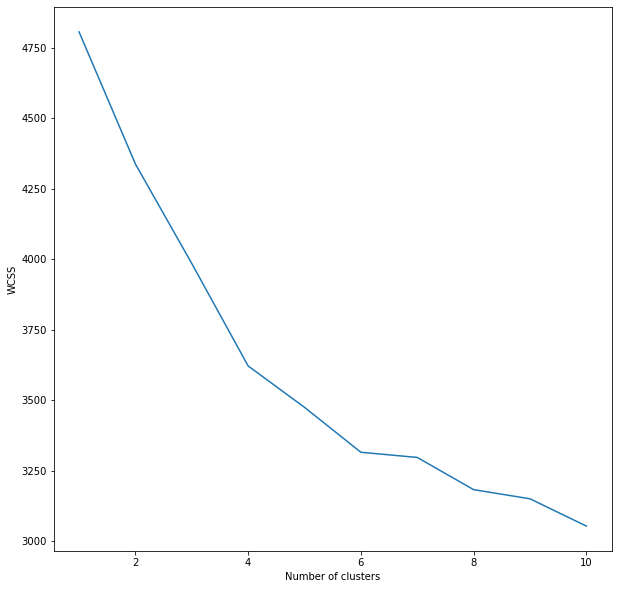

In [12]:
#elbow method to find optimal number of clusters for kmeans
wcss = []
for i in range(1,11):
   kmeans = KMeans(n_clusters = i, init = "k-means++")
   kmeans.fit(pca_result)
   wcss.append(kmeans.inertia_)
   print('Number of clusters:',i)
plt.figure(figsize=(10,10))
plt.plot(range(1,11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

#### Its difficult to see where the "elbow" is to determine the optimal number of clusters, so i would try another technique

silhouette_score of 2 clusters is: 0.1568734686830686
silhouette_score of 3 clusters is: 0.1876513243704869
silhouette_score of 4 clusters is: 0.23263237259396963
silhouette_score of 5 clusters is: 0.2605748213353883
silhouette_score of 6 clusters is: 0.24329653483615232
silhouette_score of 7 clusters is: 0.2212772019828507
silhouette_score of 8 clusters is: 0.2346002410447731
silhouette_score of 9 clusters is: 0.2698582360053474
silhouette_score of 10 clusters is: 0.26441420564211315
silhouette_score of 11 clusters is: 0.28491880396096286


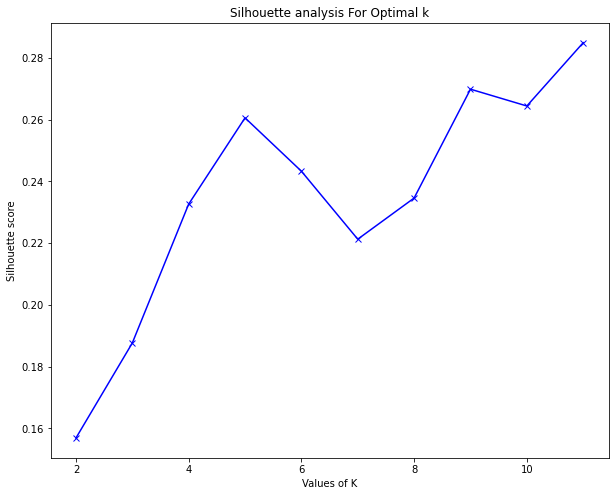

In [13]:
#silhouette score method to find optimal number of clusters for kmeans
range_n_clusters = [i for i in range(2,11)]
silhouette_avg = []
for num_clusters in range_n_clusters:
     # initialise kmeans
     kmeans = KMeans(n_clusters=num_clusters)
     kmeans.fit(pca_result)
     #cluster_labels= kmeans.labels_
     # silhouette score
     print(f'silhouette_score of {num_clusters} clusters is:',silhouette_score(pca_result, kmeans.labels_, metric='euclidean'))   
     silhouette_avg.append(silhouette_score(pca_result, kmeans.labels_, metric='euclidean'))
plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

#### It can clearly be seen that 10 number of clusters is the most optimal here

In [14]:
#running kmeans n optimal number of clusters
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans = kmeans.fit(pca_result)
kmeans.labels_
# "predictions" for new data
predictions = kmeans.predict(pca_result)

In [15]:
tweets['clusters']=kmeans.labels_
tweets['clusters'].value_counts()

8    3200
9     753
2     505
5     479
4     419
1     324
7     285
0     121
6     102
3      82
Name: clusters, dtype: int64

In [16]:
#selecting only clusters containing relevant tweets
tweets=tweets[(tweets['clusters']==1)|(tweets['clusters']==2)|(tweets['clusters']==3)|(tweets['clusters']==4)|(tweets['clusters']==9)]

### Feature Engineering

In [17]:
tweets.head()

,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters
0,2022-04-16,1515284652889722880,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,1,royal society player rumble kong league lazy l...,2
6,2022-04-16,1515194035568361475,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,7,royal society player rumble kong league lazy l...,2
10,2022-04-15,1515103488518283278,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,11,royal society player rumble kong league lazy l...,2
14,2022-04-15,1515012912376602624,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,15,royal society player rumble kong league lazy l...,2
22,2022-04-15,1514922259210776584,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,23,royal society player rumble kong league lazy l...,2


In [18]:
tweets['likes'].describe()

count    2083.000000
mean        3.079693
std        26.804149
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max      1176.000000
Name: likes, dtype: float64

In [19]:
tweets['retweets'].describe()

count    2083.000000
mean        0.793087
std        18.403053
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       836.000000
Name: retweets, dtype: float64

In [20]:
#creating popular tweets and very popular tweets from likes and retweets
tweets['popular_tweet']=(tweets['retweets']>np.percentile(tweets['retweets'],75)) | (tweets['likes']>np.percentile(tweets['likes'],75))
tweets['very_popular_tweet']=(tweets['retweets']>np.percentile(tweets['retweets'],95)) | (tweets['likes']>np.percentile(tweets['likes'],95))

#### Popular tweet corresponds to any tweet that has either its likes or retweets in the 75th percentile of all likes or retweets
#### Very Popular tweet corresponds to any tweet that has either its likes or retweets in the 95th percentile of all likes or retweets

In [21]:
tweets.head()

,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet
0,2022-04-16,1515284652889722880,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,1,royal society player rumble kong league lazy l...,2,False,False
6,2022-04-16,1515194035568361475,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,7,royal society player rumble kong league lazy l...,2,False,False
10,2022-04-15,1515103488518283278,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,11,royal society player rumble kong league lazy l...,2,False,False
14,2022-04-15,1515012912376602624,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,15,royal society player rumble kong league lazy l...,2,False,False
22,2022-04-15,1514922259210776584,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,23,royal society player rumble kong league lazy l...,2,False,False


In [22]:
tweets['popular_tweet'].value_counts()

False    1587
True      496
Name: popular_tweet, dtype: int64

In [23]:
tweets['very_popular_tweet'].value_counts()

False    1961
True      122
Name: very_popular_tweet, dtype: int64

In [24]:
tweets['word_count'] = tweets['tweet_cleaned'].apply(lambda x : len(x.split()))

In [25]:
#obtaining sentiments for the tweets
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment_polarity = blob.sentiment.polarity
    sentiment_subjectivity = blob.sentiment.subjectivity
    if sentiment_polarity > 0:
        sentiment_label = 'Positive'
    elif sentiment_polarity < 0:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'
    result = {'polarity':sentiment_polarity,
              'subjectivity':sentiment_subjectivity,
              'sentiment':sentiment_label}
    return result

In [26]:
tweets['sentiment_results'] = tweets['tweet_cleaned'].apply(get_sentiment)

In [27]:
len(tweets)

2083

In [28]:
sentiment=pd.json_normalize(tweets['sentiment_results'])

In [29]:
len(tweets),len(sentiment)

(2083, 2083)

In [30]:
tweets=tweets.reset_index()
sentiment=sentiment.reset_index()

In [31]:
tweets=(pd.concat([tweets,sentiment],axis=1))

In [32]:
tweets.tail()

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment
2078,5628,2021-10-19,1450516286719545350,The #1 Collection by Volume (last 10 mins):\np...,spr3adsh33t,0,2,5625,collection volume last min parallel parallelal...,4,False,False,19,"{'polarity': 0.09375, 'subjectivity': 0.329166...",2078,0.09375,0.329167,Positive
2079,5985,2021-08-27,1431289478530928641,Top 5 trending NFT collectibles on OpenSea ove...,JohnTodaro1,0,4,5982,top trending nft collectible opensea week cryp...,9,True,False,18,"{'polarity': -0.125, 'subjectivity': 0.575, 's...",2079,-0.12500,0.575000,Negative
2080,6000,2021-08-26,1430815649690005508,The #1 Collection by Volume (last 10 mins):\np...,spr3adsh33t,0,0,5997,collection volume last min parallel parallelal...,4,False,False,19,"{'polarity': 0.09375, 'subjectivity': 0.329166...",2080,0.09375,0.329167,Positive
2081,6001,2021-08-26,1430803023211683842,The #1 Collection by Volume (last 10 mins):\np...,spr3adsh33t,0,0,5998,collection volume last min parallel parallelal...,4,False,False,19,"{'polarity': 0.09375, 'subjectivity': 0.329166...",2081,0.09375,0.329167,Positive
2082,6030,2021-08-24,1429982308799553541,The #1 Collection by Volume (last 10 mins):\np...,spr3adsh33t,0,0,6029,collection volume last min parallel parallelal...,4,False,False,19,"{'polarity': 0.09375, 'subjectivity': 0.329166...",2082,0.09375,0.329167,Positive


In [33]:
tweets.isnull().sum()

index                 0
date                  0
tweet_id              0
tweet                 0
username              0
retweets              0
likes                 0
id                    0
tweet_cleaned         0
clusters              0
popular_tweet         0
very_popular_tweet    0
word_count            0
sentiment_results     0
index                 0
polarity              0
subjectivity          0
sentiment             0
dtype: int64

In [34]:
#obtaining how readable a tweet is
tweets['readability']=[flesch_reading_ease(i) for i in tweets['tweet_cleaned'].apply(str)]

<AxesSubplot:>

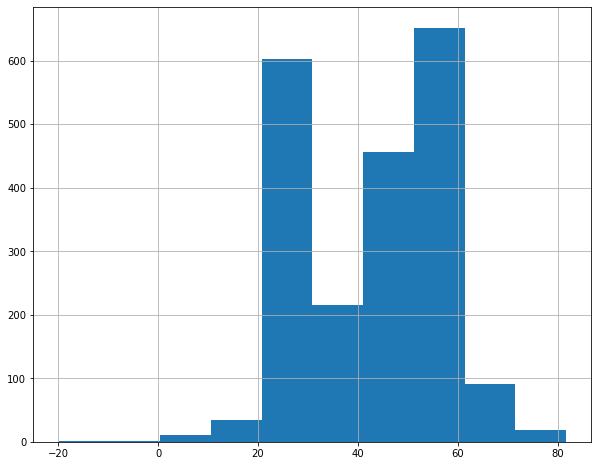

In [121]:
tweets['readability'].hist()

#### Higher scores indicate material that is easier to read, lower numbers mark harder-to-read passages: 0-30 College , 50-60 High school , 60+ Fourth grade
#### It can be seen that most of the readability scores are around 40 to 60, which means that an average high school student can read and understand these tweets

In [35]:
tweets.head()

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment,readability
0,0,2022-04-16,1515284652889722880,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,1,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",0,-0.125,0.5,Negative,22.75
1,6,2022-04-16,1515194035568361475,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,7,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",1,-0.125,0.5,Negative,22.75
2,10,2022-04-15,1515103488518283278,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,11,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",2,-0.125,0.5,Negative,22.75
3,14,2022-04-15,1515012912376602624,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,15,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",3,-0.125,0.5,Negative,22.75
4,22,2022-04-15,1514922259210776584,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,23,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",4,-0.125,0.5,Negative,22.75


In [36]:
df = tweets.copy()

In [37]:
#obtaining datetime components
df['date']=pd.to_datetime(df['date'])
df['day']=df['date'].dt.day
df['week']=df['date'].dt.week
df['month']=df['date'].dt.month

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.


<AxesSubplot:>

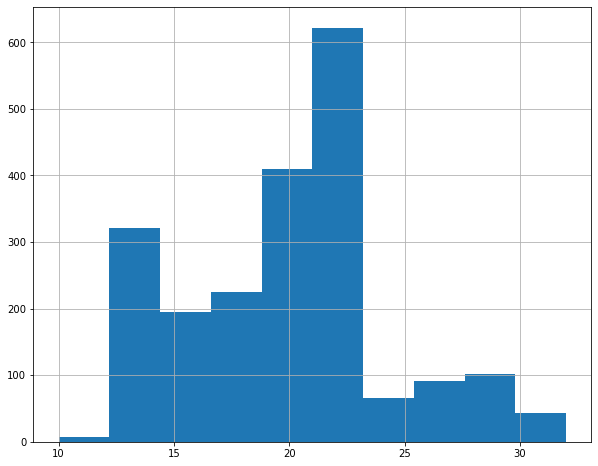

In [38]:
df['word_count'].hist()

#### Most tweets were around 22 words long, and majority of the tweets contained words fewer than 20

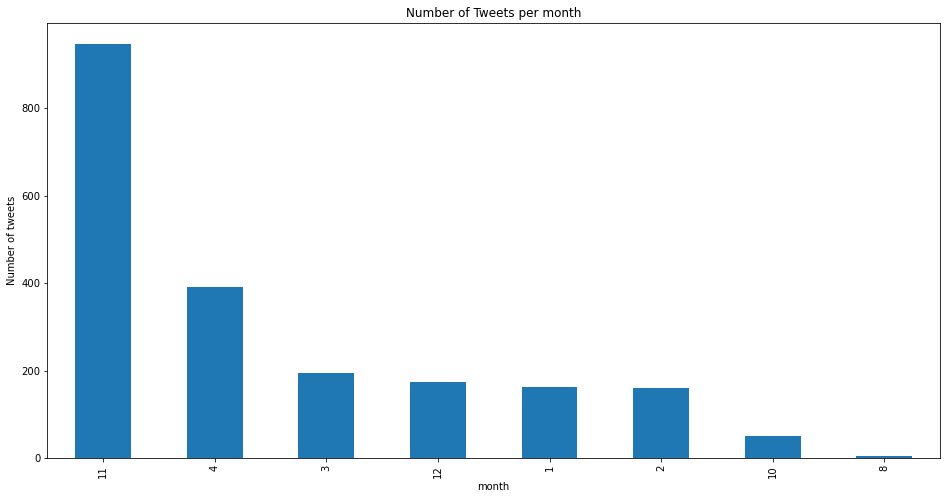

In [39]:
plt.figure(figsize=(16,8))
df['month'].value_counts().plot(kind='bar')
plt.title('Number of Tweets per month')
plt.xlabel('month')
plt.ylabel('Number of tweets');

#### November was the month with the highest number of tweets on parallel alpha, with august being the least per the data we have
#### Parallel Alpha reached its highest peak in november, thats why there is an overwhelming number of tweets in november than other months

In [40]:
parallel=pd.read_sql_query("SELECT * FROM parallel_alpha_trades",conn)
parallel.tail()

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


,chain,collectionaddress,collectionname,exchange,logindex,maker,price,quotecurrency,side,taker,thumbnailurl,timestamp,tokenid,tx,txindex,id
131357,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,153,0xe20f75642b97c11af651a81afcbbc6d7b4e32981,0.4200,ETH,buy,0xa8c045e857c1c4550119b612f22c3b27ece10340,https://storage.googleapis.com/parsec-nft-stor...,1625339709,87.0,0x2b9d31835cc90cf9206534c7da9dffd7edfbd4b900b4...,76.0,131358
131358,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,-1,0xc8301d3780efff7ee9fc579ab3b78aa5d6885a0a,0.4500,ETH,buy,0x41797b5e0398af475422f6f33f2dc81d9a24ae33,https://storage.googleapis.com/parsec-nft-stor...,1625323718,87.0,0x03d2923e72231726b99cda79073188cfb19195595530...,59.0,131359
131359,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,193,0xe20f75642b97c11af651a81afcbbc6d7b4e32981,0.3800,ETH,buy,0xf2327b04521589f505c7074c163805843a4bd6cd,https://storage.googleapis.com/parsec-nft-stor...,1625275386,87.0,0xd3168d526e49d9f361e0f8d5dec7e7d5b91733f72b0e...,116.0,131360
131360,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,198,0x52d7e31678d712ee8c15ca5af10babc257e5b61a,0.3500,ETH,buy,0x167539702b5501aadd9b0b85e53532fd57cc71a9,https://storage.googleapis.com/parsec-nft-stor...,1625220839,73.0,0x180169adcc282d403943b1a6c74a55c921547455adf4...,146.0,131361
131361,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,75,0x98c45d5ea9ccd8278fe43ba740e967a49cd19e6e,0.0099,ETH,buy,0x1c73c6174eb2fddc2e0a702e85cd3146c05aa122,https://storage.googleapis.com/parsec-nft-stor...,1625177755,10089.0,0x56d15482b8e9433db79c4fcfb0788e384cb38ec027aa...,40.0,131362


In [41]:
#obtain datetime from timestamp
from datetime import datetime
parallel['date']=parallel['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [42]:
parallel['date']=pd.to_datetime(parallel['date'])

In [43]:
df.head()

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment,readability,day,week,month
0,0,2022-04-16,1515284652889722880,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,1,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",0,-0.125,0.5,Negative,22.75,16,15,4
1,6,2022-04-16,1515194035568361475,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,7,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",1,-0.125,0.5,Negative,22.75,16,15,4
2,10,2022-04-15,1515103488518283278,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,11,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",2,-0.125,0.5,Negative,22.75,15,15,4
3,14,2022-04-15,1515012912376602624,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,0,15,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",3,-0.125,0.5,Negative,22.75,15,15,4
4,22,2022-04-15,1514922259210776584,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,23,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",4,-0.125,0.5,Negative,22.75,15,15,4


In [44]:
df['date'].min(), df['date'].max()

(Timestamp('2021-08-24 00:00:00'), Timestamp('2022-04-16 00:00:00'))

In [45]:
parallel['date'].min(), parallel['date'].max()

(Timestamp('2021-07-01 22:15:55'), Timestamp('2022-04-12 23:04:09'))

In [46]:
#extracting for only relevant dates
df=df[df['date']<='2022-04-12']
parallel=parallel[parallel['date']>'2021-08-24']

In [47]:
len(df)

1883

In [48]:
df.isnull().sum()

index                 0
date                  0
tweet_id              0
tweet                 0
username              0
retweets              0
likes                 0
id                    0
tweet_cleaned         0
clusters              0
popular_tweet         0
very_popular_tweet    0
word_count            0
sentiment_results     0
index                 0
polarity              0
subjectivity          0
sentiment             0
readability           0
day                   0
week                  0
month                 0
dtype: int64

In [49]:
#querying for only prices above 0.2 and under 2
parallel=parallel[(parallel['price']>0.2)&(parallel['price']<2)]

### Week level Aggregation of data

In [50]:
#aggregating financial data to weekly
parallel=parallel.groupby([pd.Grouper(key='date', freq='w-tue'),  'collectionname']).agg({
    'maker':['nunique'],
    'taker':['nunique'],
    'thumbnailurl':['nunique'],
    'tx':['nunique'],
    'price':['mean']})

In [51]:
df.head(1)

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment,readability,day,week,month
200,240,2022-04-12,1514016287831334916,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,240,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",200,-0.125,0.5,Negative,22.75,12,15,4


In [52]:
#aggregating twitter data to weekly
agg_df=df.groupby([pd.Grouper(key='date', freq='w-tue')]).agg({
    'word_count':['mean'],
    'popular_tweet':'first',
    'very_popular_tweet':'first',
    'readability':['mean'],
    'sentiment':'first'})

In [53]:
len(agg_df),len(parallel)

(34, 34)

In [54]:
def flatten_columns(df, prefix=''):
    columns = []
    for cs in df:
        if type(cs) is str:
            cs = re.sub('\W+','_', cs)
        elif type(cs) is not list and type(cs) is not tuple:
            print (cs)
            cs = str(cs)
        else:
            cs = re.sub("\W+", "", "".join([str(c) for c in cs]))
        cs = cs.lower()
        if prefix:
            cs = prefix + '' + cs
        cs = re.sub('\+$', '', cs)
        columns.append(cs)
    return columns

In [55]:
agg_df.columns=flatten_columns(agg_df)
parallel.columns=flatten_columns(parallel)

In [56]:
agg_df=agg_df.reset_index()
parallel=parallel.reset_index()

In [57]:
df.head()

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment,readability,day,week,month
200,240,2022-04-12,1514016287831334916,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,240,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",200,-0.125,0.5,Negative,22.75,12,15,4
201,243,2022-04-12,1513925715783299074,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,1,2,243,royal society player rumble kong league lazy l...,2,True,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",201,-0.125,0.5,Negative,22.75,12,15,4
202,244,2022-04-12,1513903051542773760,Parallel Alpha was just listed for 0.17 ETH. \...,nft_watcher_bot,0,3,244,parallel alpha listed eth http co ba bzrcpo nf...,1,True,False,14,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",202,0.000,0.0,Neutral,48.81,12,15,4
203,245,2022-04-12,1513902025116901378,Parallel Alpha was just listed for 0.0014 ETH....,nft_watcher_bot,0,1,245,parallel alpha listed eth http co z ow l saw n...,1,False,False,16,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",203,0.000,0.0,Neutral,55.24,12,15,4
204,246,2022-04-12,1513899787468292102,Parallel Alpha was just listed for 0.027 ETH. ...,nft_watcher_bot,0,0,246,parallel alpha listed eth http co kfmx cp nft ...,1,False,False,14,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",204,0.000,0.0,Neutral,57.27,12,15,4


In [58]:
parallel.head()

,date,collectionname,makernunique,takernunique,thumbnailurlnunique,txnunique,pricemean
0,2021-08-24,Parallel Alpha,821,643,77,1515,0.582914
1,2021-08-31,Parallel Alpha,963,1031,87,2898,0.529011
2,2021-09-07,Parallel Alpha,230,252,60,474,0.470613
3,2021-09-14,Parallel Alpha,144,123,51,238,0.487991
4,2021-09-21,Parallel Alpha,105,99,50,168,0.442037


### Data Processing of week level aggregates

In [59]:
parallel=parallel.rename(columns={'pricemean':'median_price',
                  'makernunique':'num_of_sellers','takernunique':'number_of_buyers','thumbnailurlnunique':'volume_of_assets_traded',
                  'txnunique':'number_of_transcations_index'})

In [60]:
len(parallel),len(agg_df)

(34, 34)

In [61]:
parallel.head(2)

,date,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,median_price
0,2021-08-24,Parallel Alpha,821,643,77,1515,0.582914
1,2021-08-31,Parallel Alpha,963,1031,87,2898,0.529011


<AxesSubplot:>

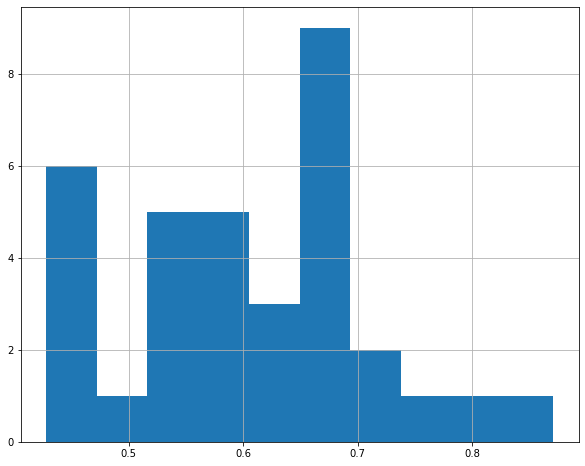

In [62]:
parallel['median_price'].hist()

#### The average price of the parallel nft is around 0.65

In [63]:
parallel.head()

,date,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,median_price
0,2021-08-24,Parallel Alpha,821,643,77,1515,0.582914
1,2021-08-31,Parallel Alpha,963,1031,87,2898,0.529011
2,2021-09-07,Parallel Alpha,230,252,60,474,0.470613
3,2021-09-14,Parallel Alpha,144,123,51,238,0.487991
4,2021-09-21,Parallel Alpha,105,99,50,168,0.442037


In [64]:
agg_df.head(1)

,date,word_countmean,popular_tweetfirst,very_popular_tweetfirst,readabilitymean,sentimentfirst
0,2021-08-24,19.0,0.0,0.0,52.19,Positive


In [65]:
agg_df['date'].min(),agg_df['date'].max()


(Timestamp('2021-08-24 00:00:00'), Timestamp('2022-04-12 00:00:00'))

In [66]:
parallel['date'].min(),parallel['date'].max()

(Timestamp('2021-08-24 00:00:00'), Timestamp('2022-04-12 00:00:00'))

In [67]:
agg_df=agg_df.reset_index()
parallel=parallel.reset_index()
agg_df=agg_df.merge(parallel, on='date')

In [68]:
agg_df.isnull().sum()

index_x                         0
date                            0
word_countmean                  6
popular_tweetfirst              6
very_popular_tweetfirst         6
readabilitymean                 6
sentimentfirst                  6
index_y                         0
collectionname                  0
num_of_sellers                  0
number_of_buyers                0
volume_of_assets_traded         0
number_of_transcations_index    0
median_price                    0
dtype: int64

In [69]:
agg_df=agg_df.dropna()
agg_df=agg_df.drop(columns=agg_df.filter(like='index'))
corr_matrix = agg_df.corr()
(corr_matrix["median_price"].sort_values(ascending=False))[:20]

median_price               1.000000
very_popular_tweetfirst    0.369006
word_countmean             0.263902
popular_tweetfirst        -0.112178
num_of_sellers            -0.159648
readabilitymean           -0.219277
number_of_buyers          -0.222576
volume_of_assets_traded   -0.240515
Name: median_price, dtype: float64

In [70]:
df.head()

,index,date,tweet_id,tweet,username,retweets,likes,id,tweet_cleaned,clusters,popular_tweet,very_popular_tweet,word_count,sentiment_results,index,polarity,subjectivity,sentiment,readability,day,week,month
200,240,2022-04-12,1514016287831334916,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,0,1,240,royal society player rumble kong league lazy l...,2,False,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",200,-0.125,0.5,Negative,22.75,12,15,4
201,243,2022-04-12,1513925715783299074,Royal Society of Players: 0.12 Ξ\nRumble Kong ...,nftflooralerts,1,2,243,royal society player rumble kong league lazy l...,2,True,False,23,"{'polarity': -0.125, 'subjectivity': 0.5, 'sen...",201,-0.125,0.5,Negative,22.75,12,15,4
202,244,2022-04-12,1513903051542773760,Parallel Alpha was just listed for 0.17 ETH. \...,nft_watcher_bot,0,3,244,parallel alpha listed eth http co ba bzrcpo nf...,1,True,False,14,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",202,0.000,0.0,Neutral,48.81,12,15,4
203,245,2022-04-12,1513902025116901378,Parallel Alpha was just listed for 0.0014 ETH....,nft_watcher_bot,0,1,245,parallel alpha listed eth http co z ow l saw n...,1,False,False,16,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",203,0.000,0.0,Neutral,55.24,12,15,4
204,246,2022-04-12,1513899787468292102,Parallel Alpha was just listed for 0.027 ETH. ...,nft_watcher_bot,0,0,246,parallel alpha listed eth http co kfmx cp nft ...,1,False,False,14,"{'polarity': 0.0, 'subjectivity': 0.0, 'sentim...",204,0.000,0.0,Neutral,57.27,12,15,4


<AxesSubplot:>

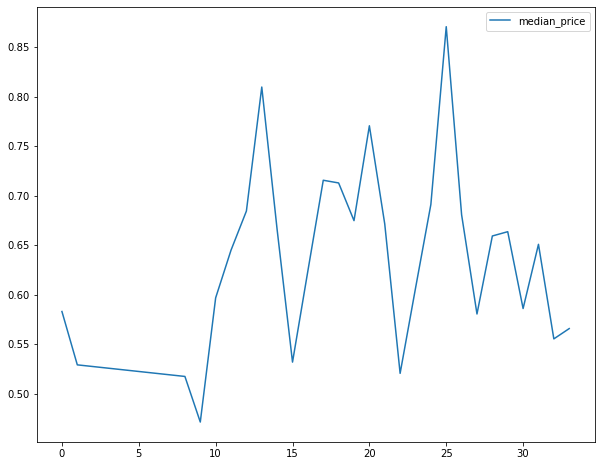

In [71]:
agg_df[['median_price']].plot(kind='line')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

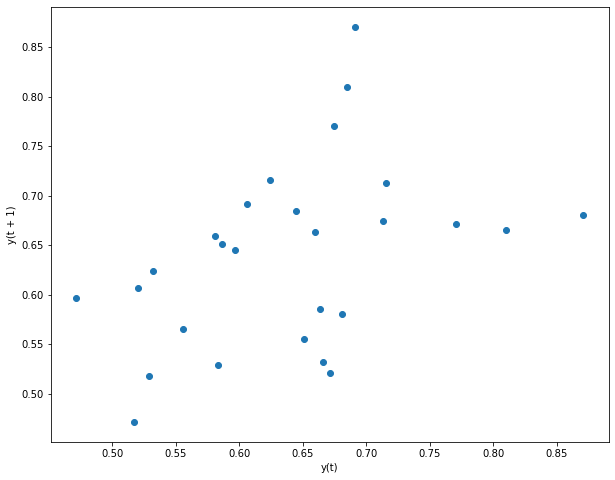

In [72]:

pd.plotting.lag_plot(agg_df['median_price'],lag=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 4)'>

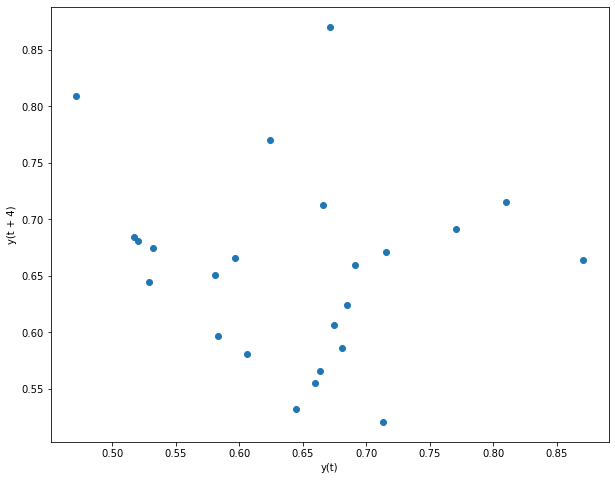

In [73]:
pd.plotting.lag_plot(agg_df['median_price'],lag=4)

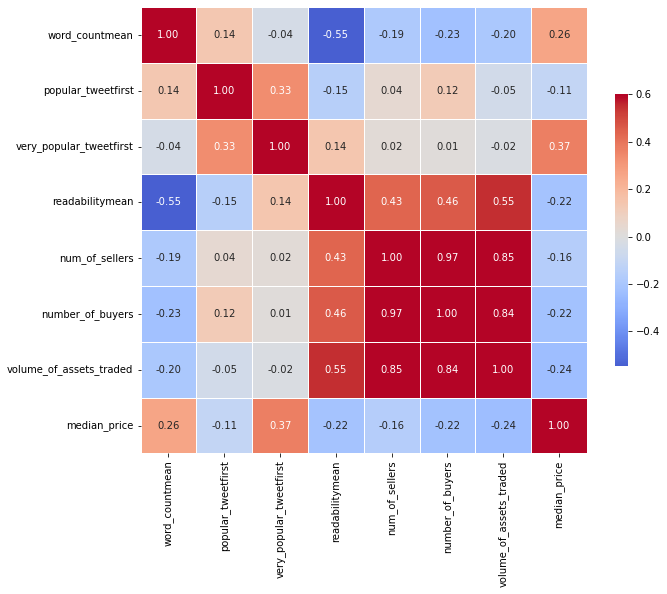

In [74]:
g = sns.heatmap(corr_matrix,  vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.figure.set_size_inches(10,10)
    
plt.show()

#### The average price of this nft has good correlations with the other features, with the best positive correlation being if a tweet is very popular
#### And the volume_of_assets_traded is the best negative correlation feature, which means the higher the number of assets traded, the lower the average price

In [75]:
#Determine of Target Column is stationary or not
result = adfuller(agg_df['median_price'])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critial Values: {result[4]}')

if result[1] > 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: -3.777861348377627
p-value: 0.0031421199878699764
Critial Values: {'1%': -3.7112123008648155, '5%': -2.981246804733728, '10%': -2.6300945562130176}
Series is Stationary


#### Since the pvalue of the average price is below 0.05, it means its stationary, according to the adfuller test

In [79]:
#One hot encode categorical variable and join back to dataframe
sent=pd.get_dummies(agg_df['sentimentfirst'])
agg_df=agg_df.drop(columns=['sentimentfirst'])
agg_df=pd.concat([agg_df, sent],axis=1)
agg_df['popular_tweetfirst']=agg_df['popular_tweetfirst'].astype('object')
agg_df['very_popular_tweetfirst']=agg_df['very_popular_tweetfirst'].astype('object')
pop = pd.get_dummies(agg_df[['popular_tweetfirst','very_popular_tweetfirst']])
agg_df=agg_df.drop(columns=['popular_tweetfirst','very_popular_tweetfirst'])
agg_df=pd.concat([agg_df, pop],axis=1)

In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)


In [80]:
agg_df.head()

,date,word_countmean,readabilitymean,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,median_price,Negative,Neutral,Positive,popular_tweetfirst_0.0,popular_tweetfirst_1.0,very_popular_tweetfirst_0.0,very_popular_tweetfirst_1.0
0,2021-08-24,19.000000,52.190000,Parallel Alpha,821,643,77,0.582914,0,0,1,1,0,1,0
1,2021-08-31,18.666667,52.530000,Parallel Alpha,963,1031,87,0.529011,1,0,0,0,1,1,0
8,2021-10-19,19.000000,52.190000,Parallel Alpha,82,62,49,0.517299,0,0,1,1,0,1,0
9,2021-10-26,15.666667,48.525000,Parallel Alpha,69,69,45,0.471237,0,0,1,1,0,1,0
10,2021-11-02,19.344681,44.748979,Parallel Alpha,827,737,97,0.596750,0,0,1,1,0,1,0


In [81]:
agg_df.tail()

,date,word_countmean,readabilitymean,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,median_price,Negative,Neutral,Positive,popular_tweetfirst_0.0,popular_tweetfirst_1.0,very_popular_tweetfirst_0.0,very_popular_tweetfirst_1.0
29,2022-03-15,24.066667,35.204000,Parallel Alpha,201,118,43,0.663570,0,0,1,1,0,1,0
30,2022-03-22,24.200000,32.361600,Parallel Alpha,95,70,33,0.585938,1,0,0,0,1,1,0
31,2022-03-29,23.307692,25.040769,Parallel Alpha,53,33,28,0.650800,1,0,0,0,1,1,0
32,2022-04-05,22.531250,25.605313,Parallel Alpha,34,27,20,0.555254,1,0,0,0,1,1,0
33,2022-04-12,15.343373,45.201325,Parallel Alpha,42,33,26,0.565667,1,0,0,1,0,1,0


### Time series Modelling

### ARIMA

In [86]:
arima=agg_df[['date','median_price']]

In [87]:
arima=arima.set_index('date')

<AxesSubplot:xlabel='date'>

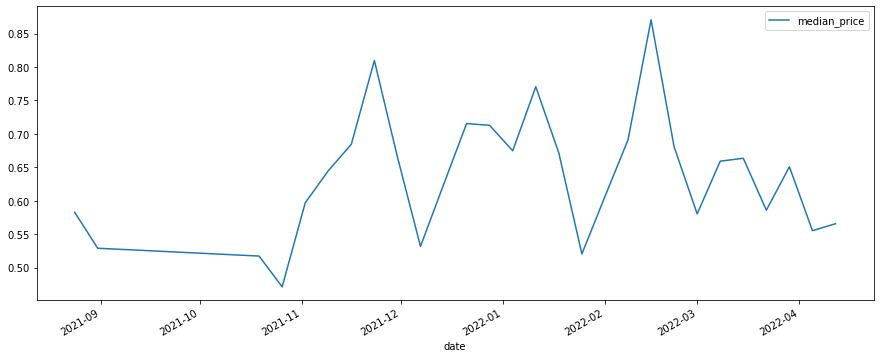

In [89]:
arima.plot(figsize=(15, 6))

In [90]:
arima_model = sm.tsa.statespace.SARIMAX(arima,order=(0, 1, 0),seasonal_order=(1, 1, 1, 12),
                                eenforce_invertibility=False)
                                
results = arima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.33590D-01    |proj g|=  4.67157D-01

At iterate    5    f= -4.37786D-01    |proj g|=  5.53907D-01

At iterate   10    f= -4.66721D-01    |proj g|=  1.93914D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     23      1     0     0   9.299D-05  -4.667D-01
  F = -0.46672288678211560     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
 This problem is unconstrained.


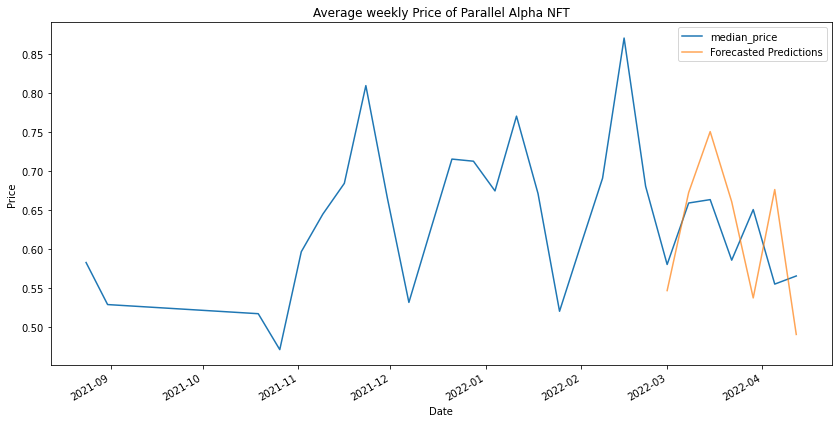

The Root Mean Squared Error of our forecasts is 0.07405929422584934


In [124]:
pred = results.get_prediction('2022-03-01', dynamic=False)
ax = arima['2021':].plot(label='Real')
pred.predicted_mean.plot(ax=ax, label='Forecasted Predictions', alpha=.7, figsize=(14, 7))
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.title('Average weekly Price of Parallel Alpha NFT')
plt.show()
y_forecasted = pred.predicted_mean
y_truth = arima['2022-03-01':]
print('The Root Mean Squared Error of our forecasts is {}'.format(mean_absolute_error(y_truth, y_forecasted)))

#### As can be seen, the mean absolute error is 0.07, and from the plot it can be seen that the forecast follows the trend of the actual, which suggests, it does well to forecast the price

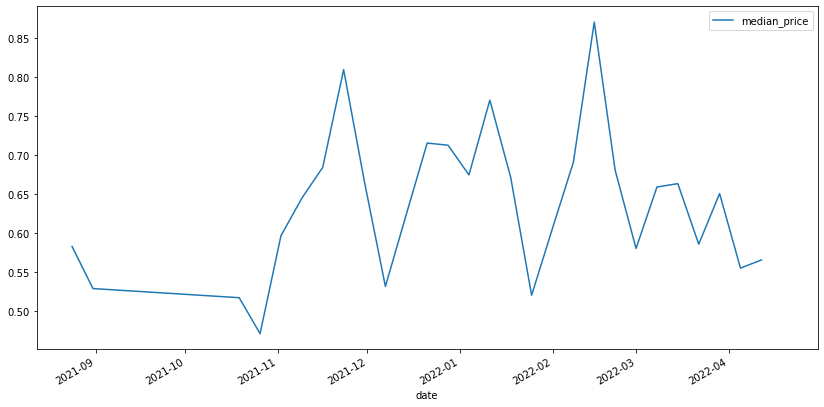

In [94]:
fcast_index = pd.to_datetime(['2022-04-19'])
pred_uc = results.get_forecast(steps=1 , index=fcast_index)
ax = arima.plot(label='Real', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecasted')
plt.show()

In [96]:
forecast_cols=(pd.DataFrame(pred_uc.predicted_mean).reset_index()).rename(columns={'index':'date','predicted_mean':'median_price'})

In [97]:
agg_df[['date','median_price']].head(1)

,date,median_price
0,2021-08-24,0.582914


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


<AxesSubplot:xlabel='date'>

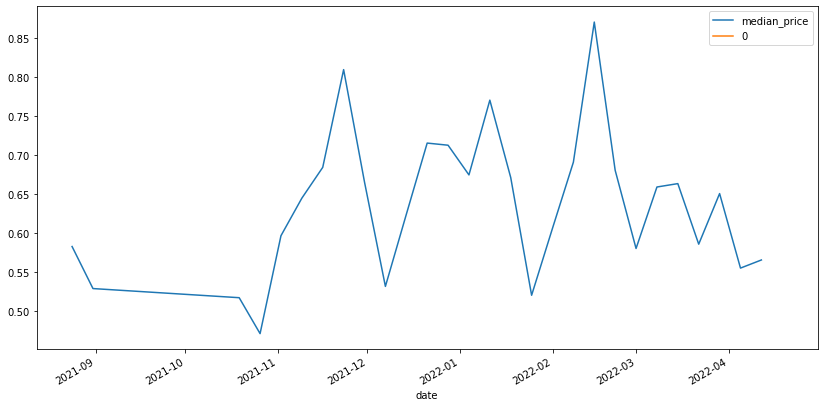

In [98]:
actual_cols=agg_df[['date','median_price']]
(actual_cols.append(forecast_cols)).set_index('date').plot(figsize=(14, 7))

#### This is how the Average price looks with the addition of the forecast next week price

### Prophet

In [99]:
df_prophet=agg_df.drop(columns=['collectionname']).reset_index()[['date','num_of_sellers','number_of_buyers','volume_of_assets_traded','median_price','word_countmean','readabilitymean','popular_tweetfirst_0.0','popular_tweetfirst_1.0','very_popular_tweetfirst_0.0','very_popular_tweetfirst_1.0']].rename({'date':'ds','median_price':'y'}, axis='columns')

In [100]:
df_prophet.head()

,ds,num_of_sellers,number_of_buyers,volume_of_assets_traded,y,word_countmean,readabilitymean,popular_tweetfirst_0.0,popular_tweetfirst_1.0,very_popular_tweetfirst_0.0,very_popular_tweetfirst_1.0
0,2021-08-24,821,643,77,0.582914,19.000000,52.190000,1,0,1,0
1,2021-08-31,963,1031,87,0.529011,18.666667,52.530000,0,1,1,0
2,2021-10-19,82,62,49,0.517299,19.000000,52.190000,1,0,1,0
3,2021-10-26,69,69,45,0.471237,15.666667,48.525000,1,0,1,0
4,2021-11-02,827,737,97,0.596750,19.344681,44.748979,1,0,1,0


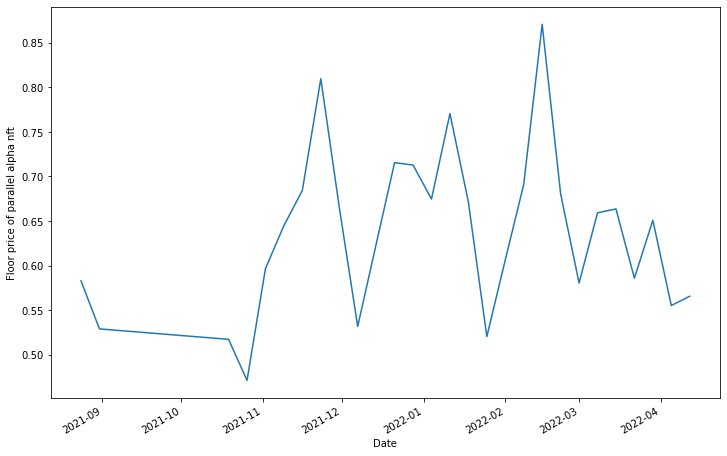

In [101]:
ax = df_prophet.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Floor price of parallel alpha nft')
ax.set_xlabel('Date')

plt.show()

In [102]:
df_prophet.head()

,ds,num_of_sellers,number_of_buyers,volume_of_assets_traded,y,word_countmean,readabilitymean,popular_tweetfirst_0.0,popular_tweetfirst_1.0,very_popular_tweetfirst_0.0,very_popular_tweetfirst_1.0
0,2021-08-24,821,643,77,0.582914,19.000000,52.190000,1,0,1,0
1,2021-08-31,963,1031,87,0.529011,18.666667,52.530000,0,1,1,0
2,2021-10-19,82,62,49,0.517299,19.000000,52.190000,1,0,1,0
3,2021-10-26,69,69,45,0.471237,15.666667,48.525000,1,0,1,0
4,2021-11-02,827,737,97,0.596750,19.344681,44.748979,1,0,1,0


In [103]:
model = Prophet(weekly_seasonality=True, growth='logistic')
model.add_regressor('num_of_sellers')
model.add_regressor('number_of_buyers')
model.add_regressor('volume_of_assets_traded')
model.add_regressor('word_countmean')
model.add_regressor('readabilitymean')
model.add_regressor('volume_of_assets_traded')
model.add_regressor('popular_tweetfirst_0.0')
model.add_regressor('popular_tweetfirst_1.0')
model.add_regressor('very_popular_tweetfirst_0.0')
model.add_regressor('very_popular_tweetfirst_1.0')


#### Adding the rest of the features for multivariate modelling

In [104]:
df_prophet['cap'] = 0.87
df_prophet['floor'] = 0.4
model.fit(df_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.



Initial log joint probability = -33.9296
Iteration  1. Log joint probability =    19.7248. Improved by 53.6544.
Iteration  2. Log joint probability =    26.5243. Improved by 6.7995.
Iteration  3. Log joint probability =    34.1035. Improved by 7.57921.
Iteration  4. Log joint probability =    37.5295. Improved by 3.42603.
Iteration  5. Log joint probability =     37.768. Improved by 0.238507.
Iteration  6. Log joint probability =    38.2684. Improved by 0.500386.
Iteration  7. Log joint probability =    38.3334. Improved by 0.0650032.
Iteration  8. Log joint probability =     38.362. Improved by 0.0285445.
Iteration  9. Log joint probability =    38.4154. Improved by 0.0534383.
Iteration 10. Log joint probability =    38.4585. Improved by 0.0431102.
Iteration 11. Log joint probability =    38.4626. Improved by 0.00404926.
Iteration 12. Log joint probability =    38.4633. Improved by 0.000779422.
Iteration 13. Log joint probability =    38.4712. Improved by 0.00782751.
Iteration 14. Lo

In [105]:
future_dates=model.make_future_dataframe(periods=1, freq='w-tue')
future_dates.head(2)

,ds
0,2021-08-24
1,2021-08-31


In [106]:
agg_df.head(1)

,date,word_countmean,readabilitymean,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,median_price,Negative,Neutral,Positive,popular_tweetfirst_0.0,popular_tweetfirst_1.0,very_popular_tweetfirst_0.0,very_popular_tweetfirst_1.0
0,2021-08-24,19.0,52.19,Parallel Alpha,821,643,77,0.582914,0,0,1,1,0,1,0


In [107]:
fut_features=df_prophet.drop(columns=['ds','y'])

In [108]:
past_month=fut_features.tail(4)
past_month.head()

,num_of_sellers,number_of_buyers,volume_of_assets_traded,word_countmean,readabilitymean,popular_tweetfirst_0.0,popular_tweetfirst_1.0,very_popular_tweetfirst_0.0,very_popular_tweetfirst_1.0,cap,floor
24,95,70,33,24.200000,32.361600,0,1,1,0,0.87,0.4
25,53,33,28,23.307692,25.040769,0,1,1,0,0.87,0.4
26,34,27,20,22.531250,25.605313,0,1,1,0,0.87,0.4
27,42,33,26,15.343373,45.201325,1,0,1,0,0.87,0.4


In [109]:
future_dates=pd.concat([future_dates,fut_features],axis=1)

In [110]:
future_dates=future_dates.fillna(past_month.median())

In [111]:
#future_dates['cap'] = 0.87
#future_dates['floor'] = 0.4
forecast = model.predict(future_dates)
forecast[['ds', 'yhat']]

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,ds,yhat
0,2021-08-24,0.605195
1,2021-08-31,0.501333
2,2021-10-19,0.598572
3,2021-10-26,0.578720
4,2021-11-02,0.579521
5,2021-11-09,0.654097
6,2021-11-16,0.577004
7,2021-11-23,0.809695
8,2021-11-30,0.653592
9,2021-12-07,0.670111


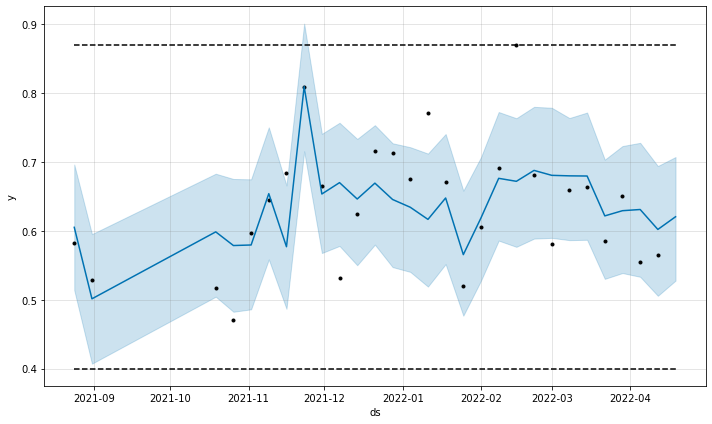

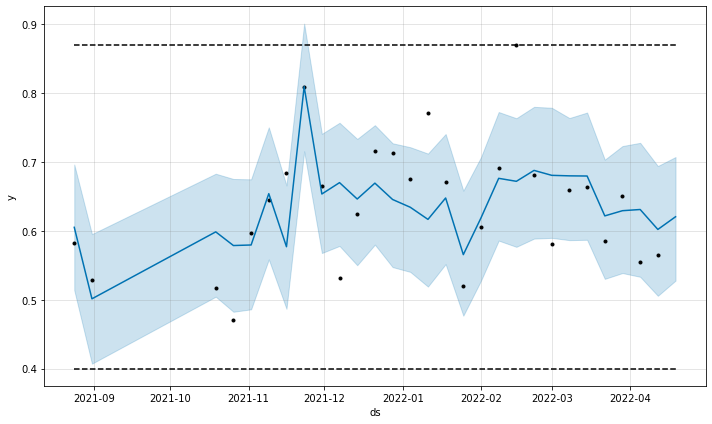

In [112]:
model.plot(forecast, uncertainty=True)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


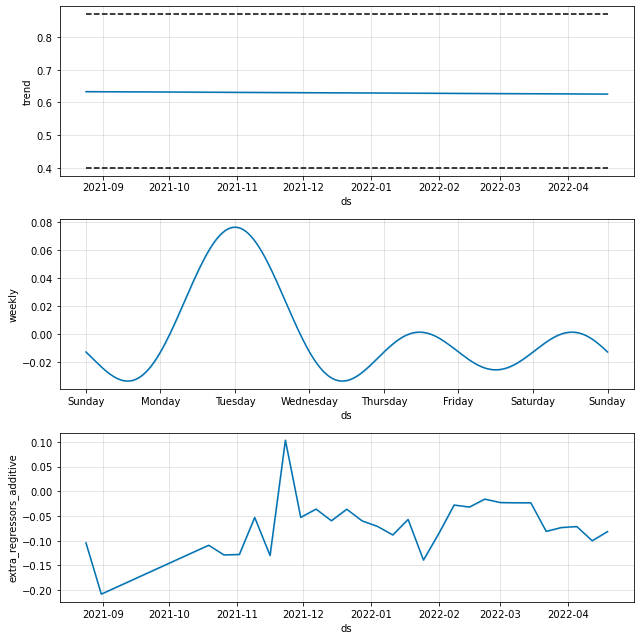

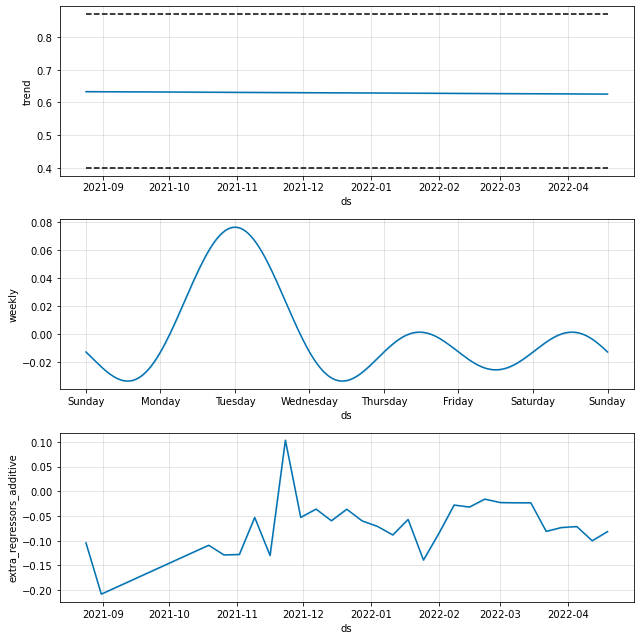

In [113]:
model.plot_components(forecast)

In [114]:
actual_cols=agg_df[['date','median_price']]
forecast_cols=forecast[['ds','yhat']]
forecast_cols.columns=['date','median_price']
all_cols=actual_cols.append(forecast_cols.tail(2))

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [115]:
all_cols.tail(5)

,date,median_price
31,2022-03-29,0.650800
32,2022-04-05,0.555254
33,2022-04-12,0.565667
27,2022-04-12,0.602099
28,2022-04-19,0.620525


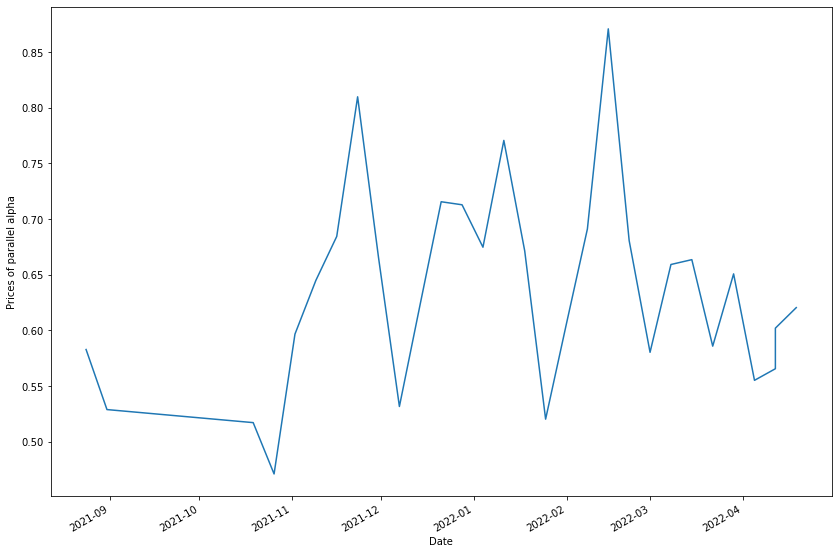

In [116]:
ax = all_cols.set_index('date')['median_price'].plot(figsize=(14, 10))
ax.set_ylabel('Prices of parallel alpha')
ax.set_xlabel('Date')
#axvline(linewidth=4, color='r')
plt.show()

#### This is how the plot of the avergae price of the nft weekly looks with the addition of the forecasted week

In [117]:
from fbprophet.diagnostics import cross_validation,  performance_metrics
cv_results = cross_validation( model = model, initial = '10 w', horizon = '10 w')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:Making 3 forecasts with cutoffs between 2021-11-23 00:00:00 and 2022-02-01 00:00:00
  0%|                                                     | 0/3 [00:00<?, ?it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.



Initial log joint probability = -52.1701
Iteration  1. Log joint probability =    2.87235. Improved by 55.0425.
Iteration  2. Log joint probability =    7.74473. Improved by 4.87237.
Iteration  3. Log joint probability =    9.91472. Improved by 2.16999.
Iteration  4. Log joint probability =    14.7497. Improved by 4.83499.
Iteration  5. Log joint probability =    18.5585. Improved by 3.80882.
Iteration  6. Log joint probability =    23.4775. Improved by 4.91902.
Iteration  7. Log joint probability =    29.8064. Improved by 6.32888.
Iteration  8. Log joint probability =    35.2707. Improved by 5.46426.
Iteration  9. Log joint probability =    39.6987. Improved by 4.42804.
Iteration 10. Log joint probability =    43.9199. Improved by 4.22121.
Iteration 11. Log joint probability =    48.4821. Improved by 4.5622.
Iteration 12. Log joint probability =    52.5371. Improved by 4.05499.
Iteration 13. Log joint probability =    57.4585. Improved by 4.92141.
Iteration 14. Log joint probability 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 33%|███████████████                              | 1/3 [00:01<00:03,  1.89s/it]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.



Initial log joint probability = -47.1673
Iteration  1. Log joint probability =    6.22766. Improved by 53.395.
Iteration  2. Log joint probability =    13.5061. Improved by 7.27844.
Iteration  3. Log joint probability =    18.1106. Improved by 4.60448.
Iteration  4. Log joint probability =    18.3002. Improved by 0.189599.
Iteration  5. Log joint probability =    21.1899. Improved by 2.88968.
Iteration  6. Log joint probability =    21.2004. Improved by 0.0105333.
Iteration  7. Log joint probability =    21.2016. Improved by 0.00115602.
Iteration  8. Log joint probability =    21.2187. Improved by 0.0171009.
Iteration  9. Log joint probability =    21.3155. Improved by 0.0968074.
Iteration 10. Log joint probability =    21.6019. Improved by 0.286457.
Iteration 11. Log joint probability =     24.635. Improved by 3.03309.
Iteration 12. Log joint probability =    24.8452. Improved by 0.210152.
Iteration 13. Log joint probability =    24.8927. Improved by 0.0475725.
Iteration 14. Log join

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 67%|██████████████████████████████               | 2/3 [00:02<00:01,  1.25s/it]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -42.7856
Iteration  1. Log joint probability =    3.48054. Improved by 46.2661.
Iteration  2. Log joint probability =    17.5658. Improved by 14.0852.
Iteration  3. Log joint probability =    23.3108. Improved by 5.74499.
Iteration  4. Log joint probability =    24.1608. Improved by 0.850065.
Iteration  5. Log joint probability =    24.4914. Improved by 0.330594.
Iteration  6. Log joint probability =    24.7702. Improved by 0.278766.
Iteration  7. Log joint probability =    24.7899. Improved by 0.0197073.
Iteration  8. Log joint probability =    24.9364. Improved by 0.146518.
Iteration  9. Log joint probability =     25.129. Improved by 0.192564.
Iteration 10. Log joint probability =    25.3181. Improved by 0.18912.
Iteration 11. Log joint probability =    25.3391. Improved by 0.0210429.
Iteration 12. Log joint probability =     25.366. Improved by 0.0268985.
Iteration 13. Log joint probability =     25.373. Improved by 0.00690993.
Iteration 14. Log joi

100%|█████████████████████████████████████████████| 3/3 [00:03<00:00,  1.12s/it]


,horizon,mse,rmse,mae,mape,mdape,coverage
0,7 days,0.006463,0.080391,0.068213,0.101498,0.118491,0.333333
1,14 days,0.023087,0.151944,0.127624,0.200621,0.168422,0.333333
2,21 days,0.031810,0.178353,0.118281,0.176039,0.066041,0.333333
3,28 days,0.094235,0.306978,0.249589,0.456382,0.361314,0.000000
4,35 days,0.043299,0.208084,0.164034,0.262117,0.154696,0.000000
5,42 days,0.014922,0.122154,0.120554,0.177795,0.186188,0.000000
6,49 days,0.030590,0.174900,0.153409,0.216211,0.248515,0.000000
7,56 days,0.011408,0.106806,0.087110,0.129872,0.122336,0.000000
8,63 days,0.066598,0.258065,0.240315,0.429375,0.350037,0.000000
9,70 days,0.039994,0.199986,0.166840,0.268401,0.293840,0.000000


In [118]:
df_p['mae'].mean()

0.1495967453974917

In [120]:
### LSTM